# COMP4030 - Data Science and Machine Learning - Coursework 2

In [16]:
import matplotlib as mplt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

In [2]:
df = pd.read_csv('data/ash-circle/Gyroscope.csv')
df.head()

(11182, 4)

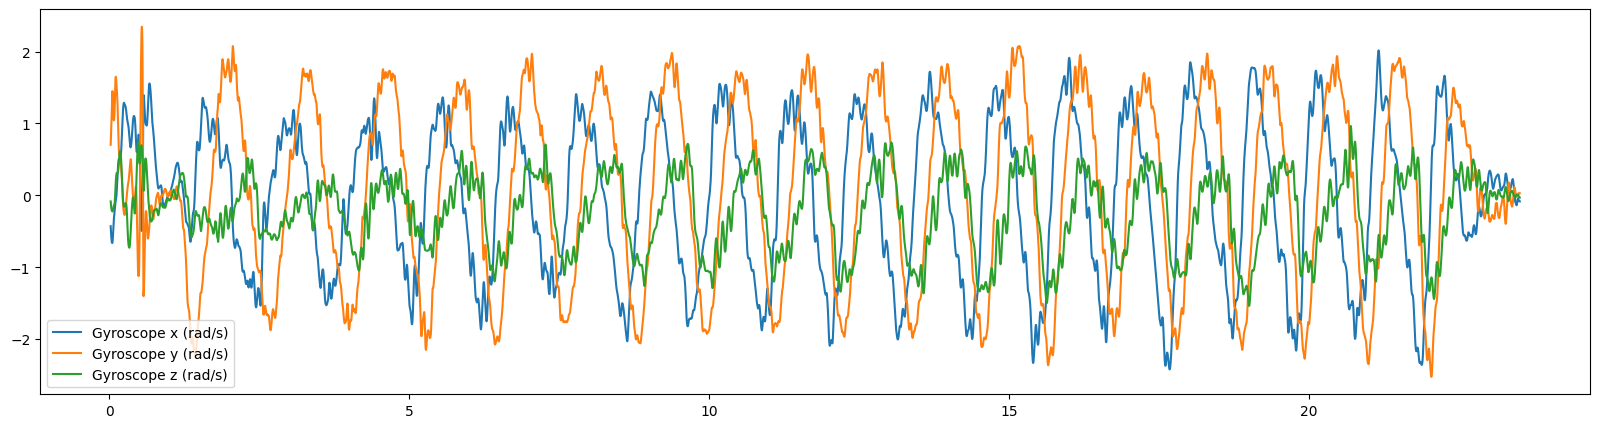

In [3]:
plt.figure(figsize=(20, 5))
for col in df.columns[1:]:
      plt.plot(df['Time (s)'], df[col], label=col)
      plt.legend()

In [4]:
df = df[df['Time (s)'] >= 1]
df = df[df['Time (s)'] <= 22]

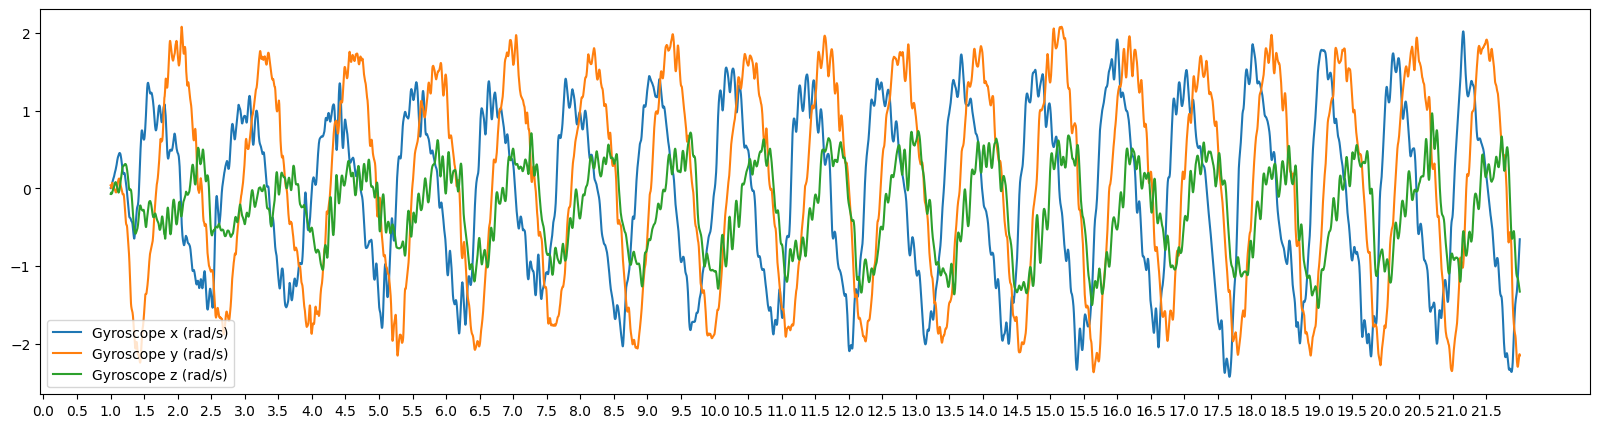

In [9]:
plt.figure(figsize=(20, 5))
for col in df.columns[1:]:
      plt.plot(df['Time (s)'], df[col], label=col)
      plt.legend()
plt.xticks(np.arange(0, df['Time (s)'].max(), 0.5))
plt.show()


ValueError: x and y must have same first dimension, but have shapes (9997,) and (70,)

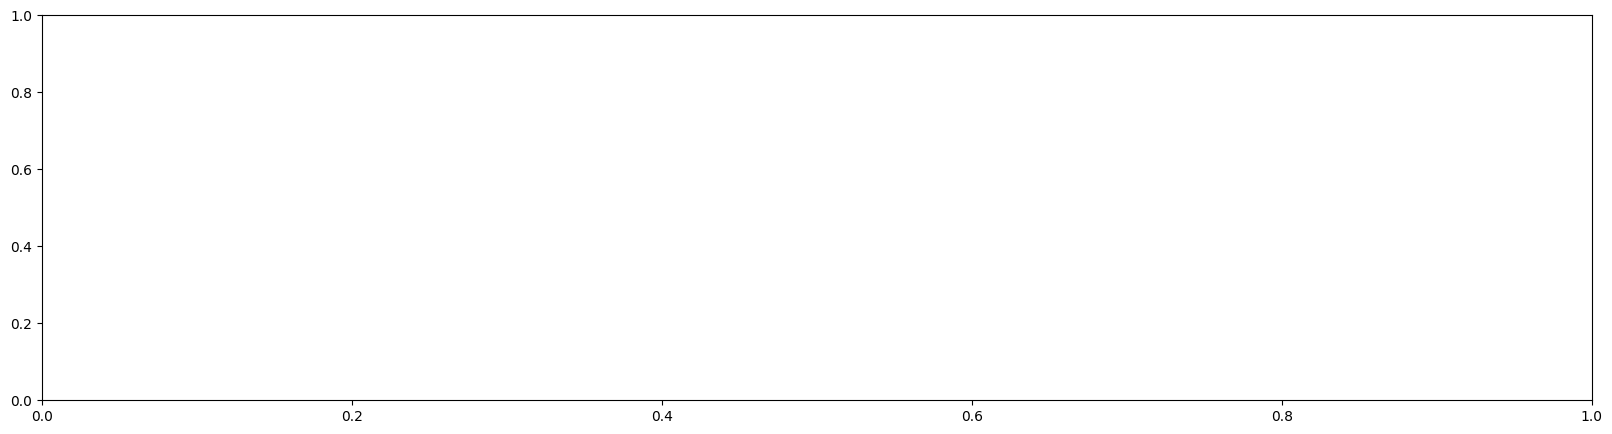

In [21]:
peaks, _ = find_peaks(df['Gyroscope y (rad/s)'], height=1.5)  # Peaks with height > 0
troughs, _ = find_peaks(-df['Gyroscope y (rad/s)'], height=-1.5)  # Troughs in the inverted data

plt.figure(figsize=(20, 5))
plt.plot(df['Time (s)'], peaks, label='peaks')  # Plot rolling average

for col in df.columns[1:]:
      rolling_avg = df[col].rolling(window=100).mean()  # Calculate rolling average
      plt.plot(df['Time (s)'], rolling_avg, label=col + ' (Rolling Avg)')  # Plot rolling average
      plt.legend()
plt.xticks(np.arange(0, df['Time (s)'].max(), 0.5))
plt.show()


array([ 421,  467,  503,  526, 1061, 1076, 1093, 1118, 1660, 1695, 1716,
       1740, 1747, 1772, 1786, 2288, 2323, 2342, 2812, 2836, 2876, 3389,
       3409, 3429, 3466, 3906, 3942, 3945, 3987, 4024, 4498, 4536, 4580,
       5022, 5065, 5115, 5556, 5601, 5618, 5658, 6127, 6151, 6173, 6646,
       6690, 6734, 6745, 6768, 7188, 7227, 7265, 7267, 7733, 7773, 8195,
       8235, 8269, 8691, 8740, 8751, 8782, 8789, 9190, 9232, 9265, 9707,
       9737, 9748, 9761, 9797], dtype=int64)